In [ ]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [ ]:
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    raw_frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray.astype(np.float32))
        raw_frames.append(frame)
    
    cap.release()
    return np.array(frames), np.array(raw_frames)


In [ ]:
video_path = "/ghome/group02/Marina/mcv-c6-2026-team2/Week1/Data/AICity_data/train/S03/c010/vdo.avi"

In [ ]:
frames, raw_frames = load_video_frames(video_path)

print("Total frames:", len(frames))

N = len(frames)
train_end = int(0.25 * N)

train_frames = frames[:train_end]
test_frames = frames[train_end:]

raw_test_frames = raw_frames[train_end:]

print("Training frames:", len(train_frames))
print("Testing frames:", len(test_frames))

In [3]:
#roi_img_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/roi.jpg"
roi_img_path = "/ghome/group02/Marina/mcv-c6-2026-team2/Week1/Data/AICity_data/train/S03/c010/roi.jpg"
roi = cv2.imread(roi_img_path, cv2.IMREAD_GRAYSCALE)
roi = roi > 0

## Task 3: computing masks using other methods

In [ ]:
fgbg_mog = cv2.bgsegm.createBackgroundSubtractorMOG()
fgbg_mog2 = cv2.createBackgroundSubtractorMOG2()
fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorGMG()
fgbg_lsbp = cv2.bgsegm.createBackgroundSubtractorLSBP()
fgbg_gsoc = cv2.bgsegm.createBackgroundSubtractorGSOC()
fgbg_knn = cv2.createBackgroundSubtractorKNN()
fgbg_cnt = cv2.bgsegm.createBackgroundSubtractorCNT()


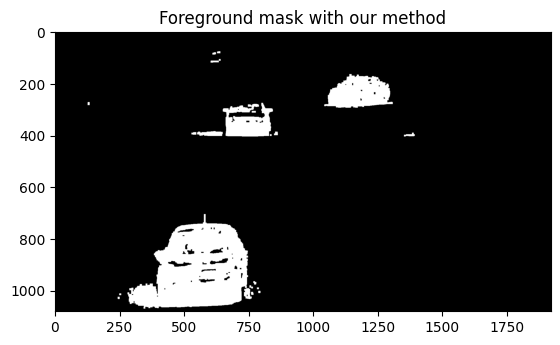

In [ ]:
plt.imshow(foreground_masks[20], cmap="gray")
plt.title("Foreground mask with our method")
plt.show()

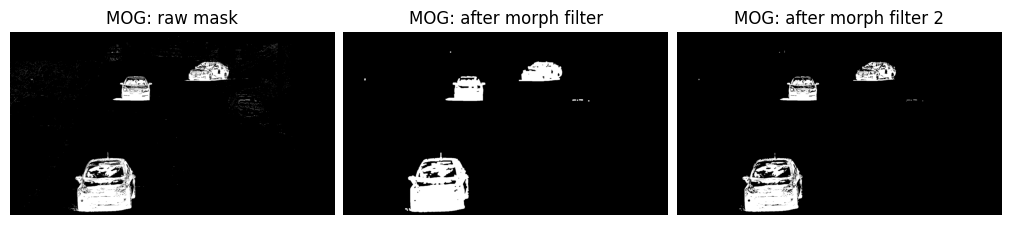

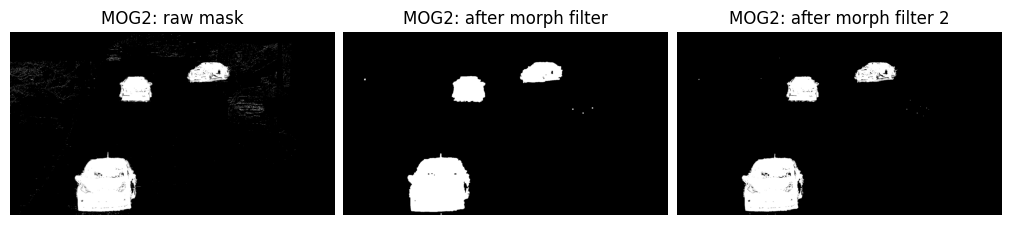

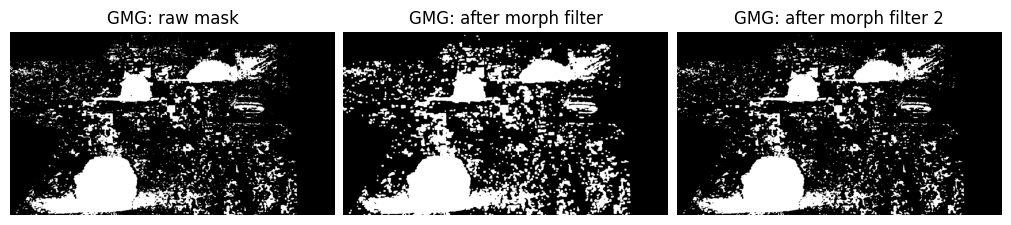

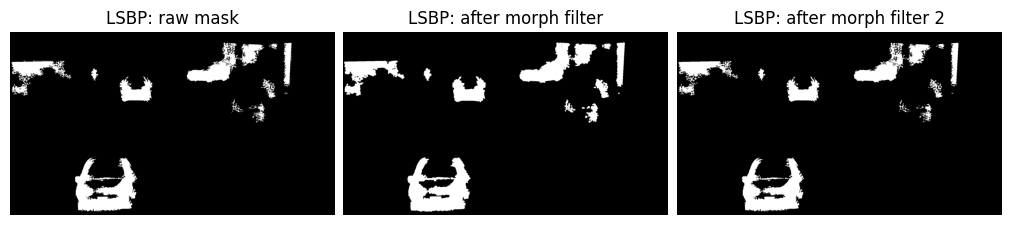

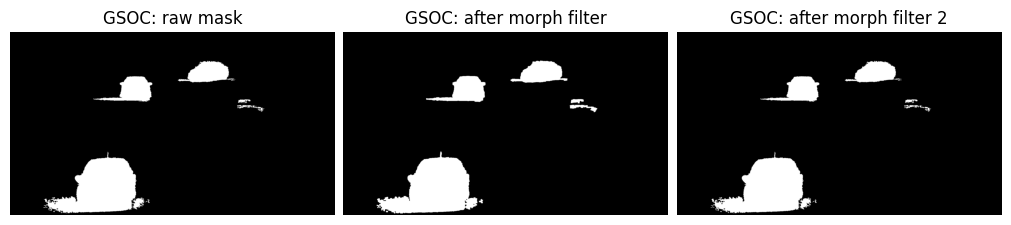

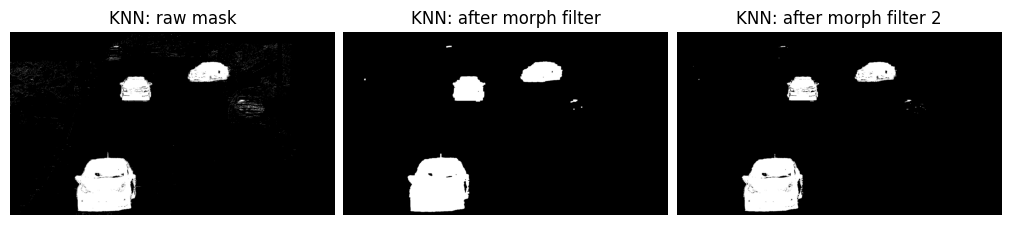

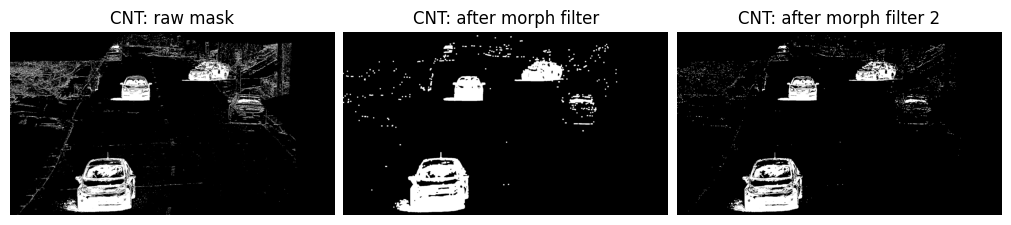

In [ ]:

models = [
    (fgbg_mog, "MOG"),
    (fgbg_mog2, "MOG2"),
    (fgbg_gmg, "GMG"),
    (fgbg_lsbp, "LSBP"),
    (fgbg_gsoc, "GSOC"),
    (fgbg_knn, "KNN"),
    (fgbg_cnt, "CNT"),
]
for fgbg, model_name in models:

    for frame in raw_frames[:train_end+21]:
        fgmask = fgbg.apply(frame)

    fgmask = fgmask * roi
    # we only want to keep values exactly 255, some models
    # predict shadows as 126 -> we want to remove those
    fgmask = (fgmask == 255).astype(np.uint8) * 255

    kernel = np.ones((5,5), np.uint8)
    kernel_open = np.ones((3,3), np.uint8)
    kernel_close = np.ones((7,7), np.uint8)

    fgmask_mf = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel_open)
    fgmask_mf = cv2.morphologyEx(fgmask_mf, cv2.MORPH_CLOSE, kernel_close)
    fgmask_mf = cv2.dilate(fgmask_mf, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)


    # side-by-side plots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

    axes[0].imshow(fgmask, cmap="gray")
    axes[0].set_title(f"{model_name}: raw mask")
    axes[0].axis("off")

    axes[1].imshow(fgmask_mf, cmap="gray")
    axes[1].set_title(f"{model_name}: after morph filter")
    axes[1].axis("off")

    axes[2].imshow(fgmask_mf2, cmap="gray")
    axes[2].set_title(f"{model_name}: after morph filter 2")
    axes[2].axis("off")

    plt.show()

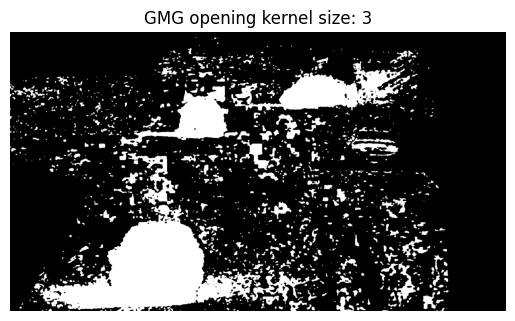

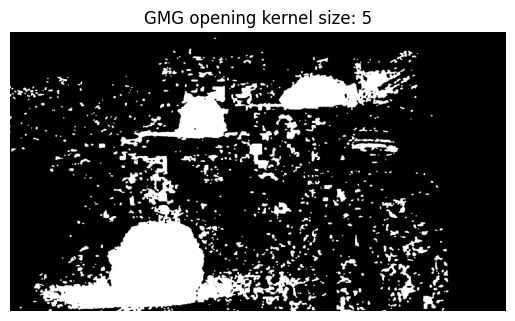

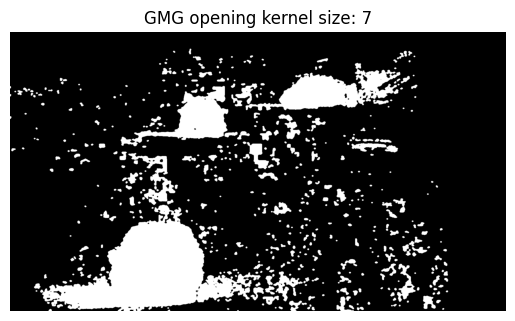

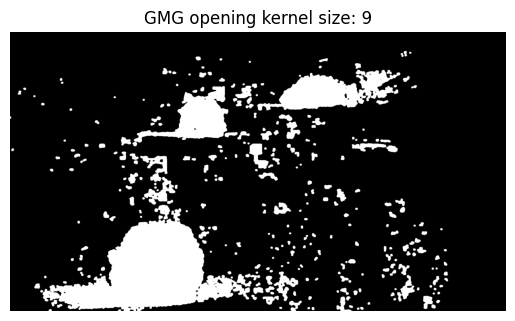

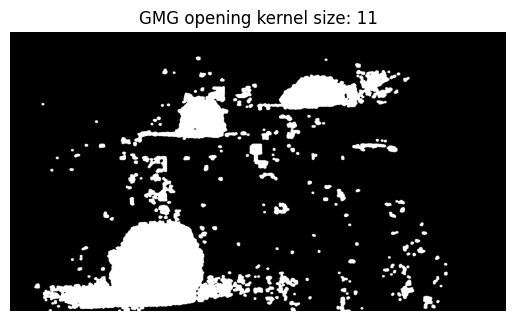

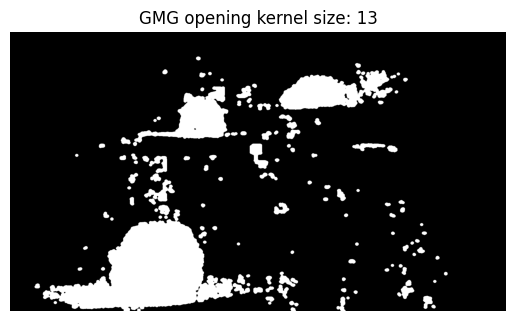

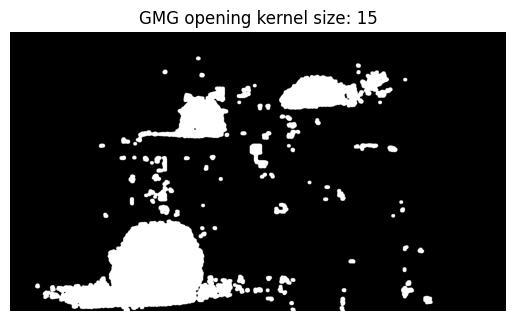

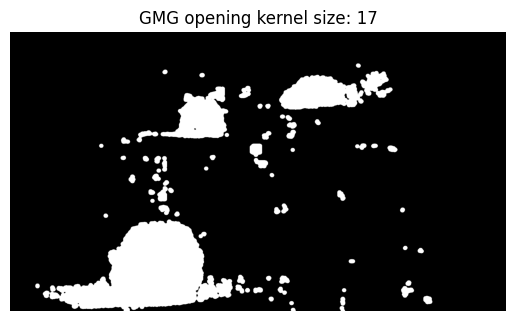

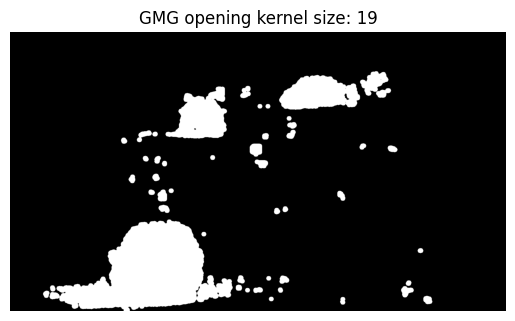

In [ ]:
for frame in raw_frames[:train_end+21]:
    fgmask = fgbg_gmg.apply(frame)

fgmask = fgmask * roi
# we only want to keep values exactly 255, some models
# predict shadows as 126 -> we want to remove those
fgmask = (fgmask == 255).astype(np.uint8) * 255

for k in [3,5,7,9,11,13,15,17,19]:

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    plt.imshow(fgmask_mf2, cmap="gray")
    plt.title(f"GMG opening kernel size: {k}")
    plt.axis("off")

    plt.show()

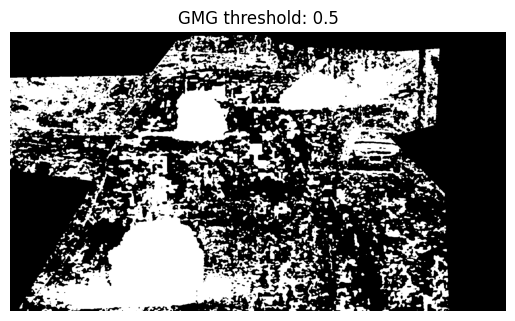

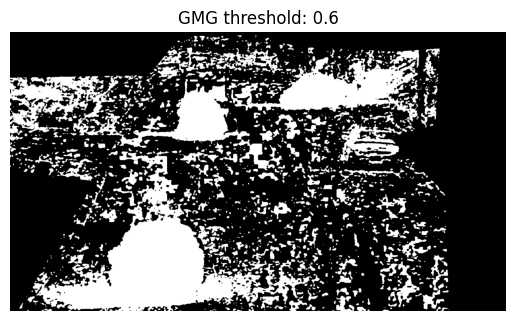

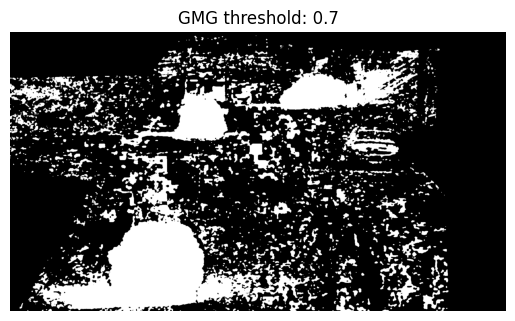

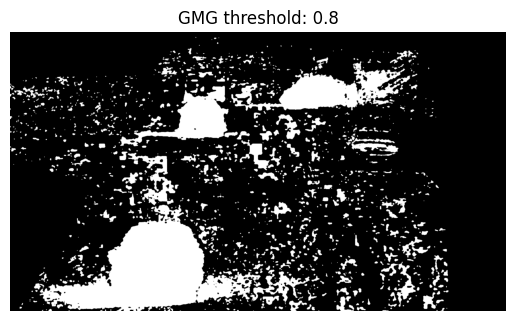

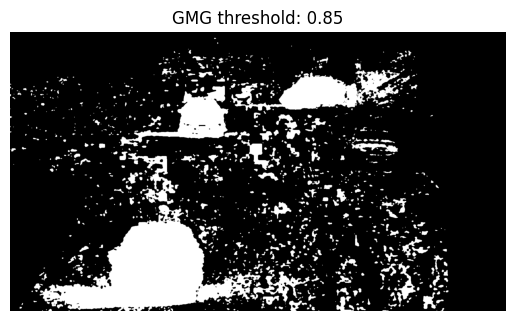

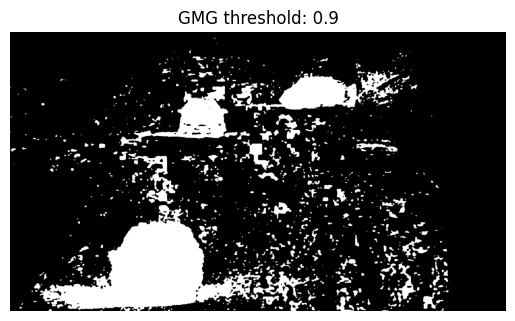

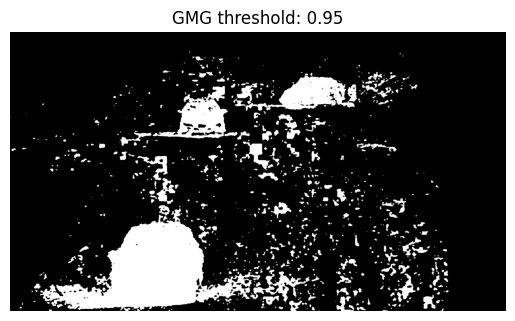

In [ ]:
for thres in [0.5,0.6,0.7,0.8, 0.85, 0.9, 0.95]:

    fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorGMG(decisionThreshold = thres)

    for frame in raw_frames[:train_end+21]:
        fgmask = fgbg_gmg.apply(frame)

    fgmask = fgmask * roi
    # we only want to keep values exactly 255, some models
    # predict shadows as 126 -> we want to remove those
    fgmask = (fgmask == 255).astype(np.uint8) * 255


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    plt.imshow(fgmask_mf2, cmap="gray")
    plt.title(f"GMG threshold: {thres}")
    plt.axis("off")

    plt.show()

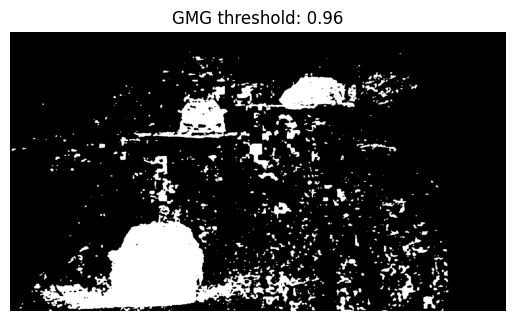

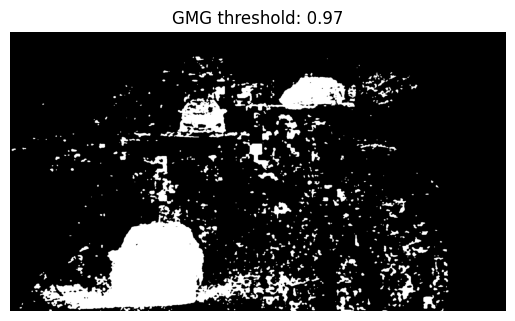

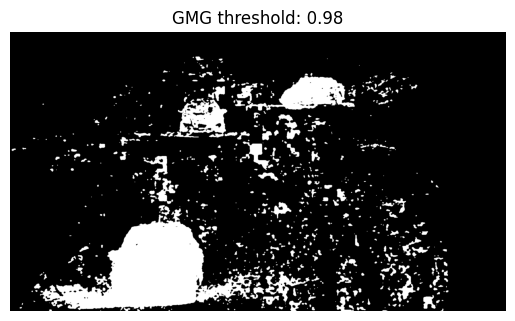

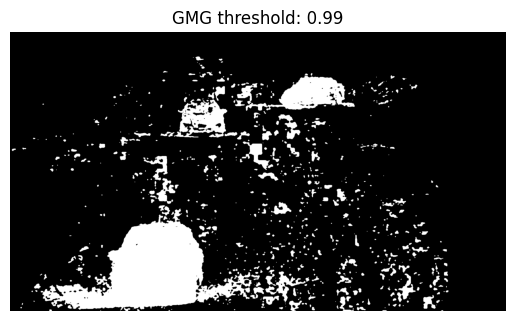

In [ ]:
for thres in [0.96, 0.97, 0.98, 0.99]:

    fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorGMG(decisionThreshold = thres)

    for frame in raw_frames[:train_end+21]:
        fgmask = fgbg_gmg.apply(frame)

    fgmask = fgmask * roi
    # we only want to keep values exactly 255, some models
    # predict shadows as 126 -> we want to remove those
    fgmask = (fgmask == 255).astype(np.uint8) * 255


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    plt.imshow(fgmask_mf2, cmap="gray")
    plt.title(f"GMG threshold: {thres}")
    plt.axis("off")

    plt.show()

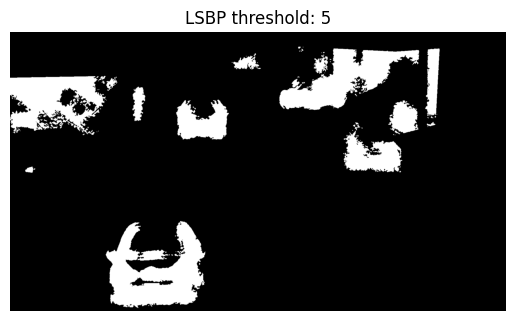

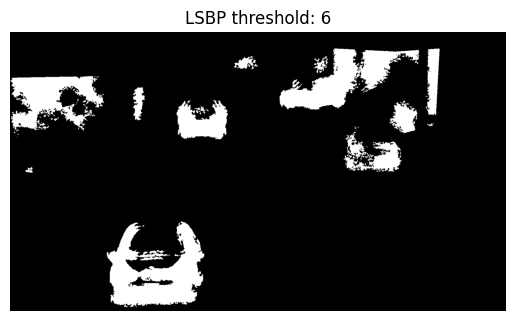

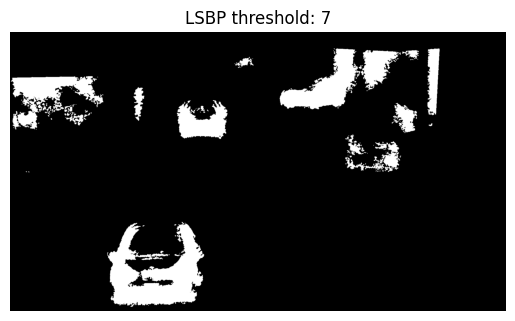

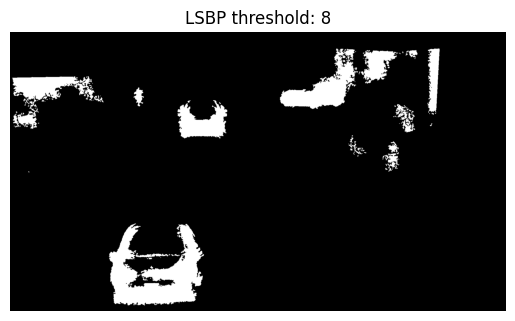

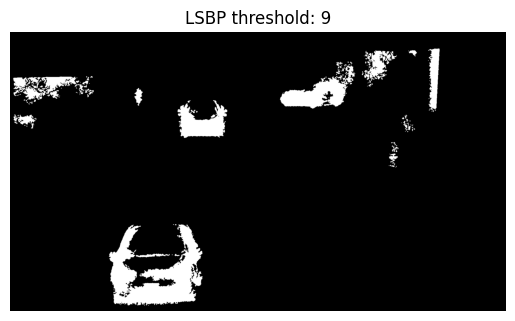

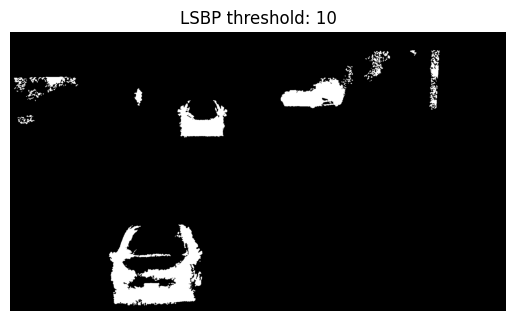

In [ ]:
for thres in [5,6,7,8, 9, 10]:

    fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorLSBP(LSBPthreshold = thres)

    for frame in raw_frames[:train_end+21]:
        fgmask = fgbg_gmg.apply(frame)

    fgmask = fgmask * roi
    # we only want to keep values exactly 255, some models
    # predict shadows as 126 -> we want to remove those
    fgmask = (fgmask == 255).astype(np.uint8) * 255


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    plt.imshow(fgmask_mf2, cmap="gray")
    plt.title(f"LSBP threshold: {thres}")
    plt.axis("off")

    plt.show()

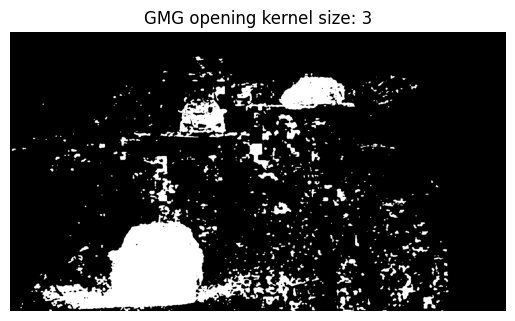

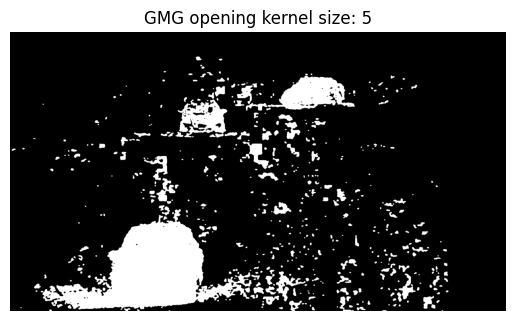

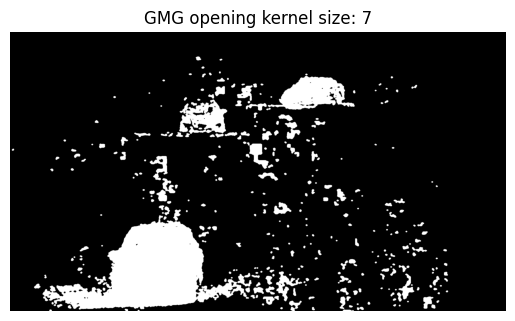

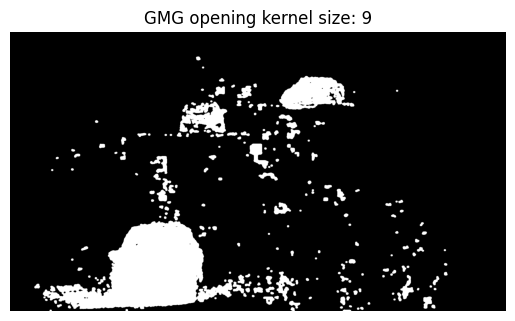

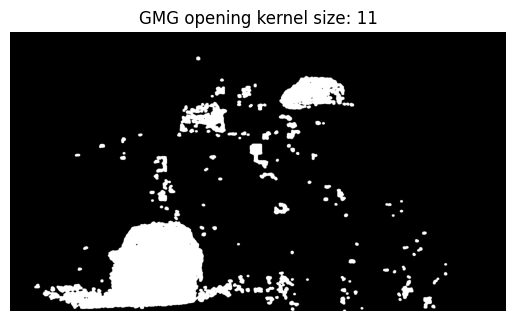

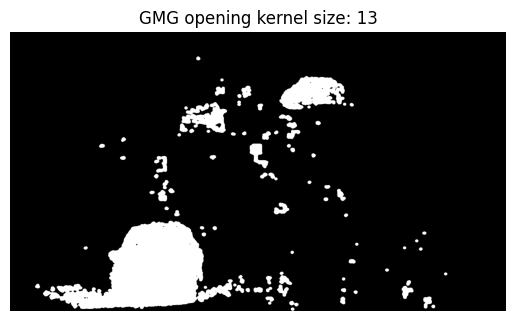

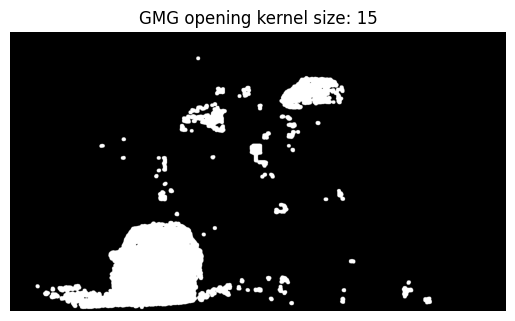

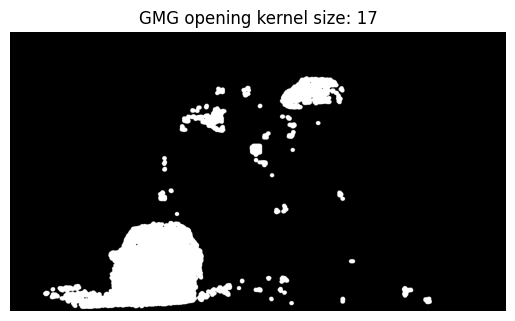

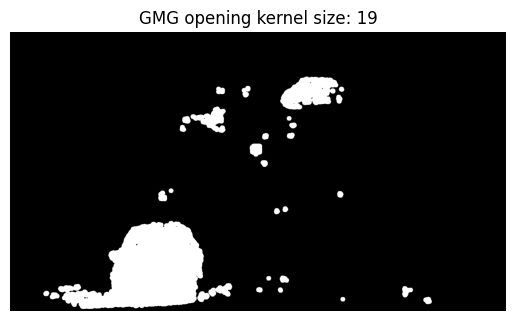

In [ ]:
fgbg_gmg_99 = cv2.bgsegm.createBackgroundSubtractorGMG(decisionThreshold = 0.99)

for frame in raw_frames[:train_end+21]:
    fgmask = fgbg_gmg_99.apply(frame)

fgmask = fgmask * roi
# we only want to keep values exactly 255, some models
# predict shadows as 126 -> we want to remove those
fgmask = (fgmask == 255).astype(np.uint8) * 255

for k in [3,5,7,9,11,13,15,17,19]:

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    fgmask_mf2 = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    plt.imshow(fgmask_mf2, cmap="gray")
    plt.title(f"GMG opening kernel size: {k}")
    plt.axis("off")

    plt.show()

In [ ]:
import os
os.chdir("../")

In [ ]:
from src.task1.task1 import Video
from src.task2.task2 import (threshold_foreground, postprocess_mask)                        


In [ ]:
os.getcwd()

'/export/home/group02/Marina/mcv-c6-2026-team2/Week1'

In [ ]:
video = Video(video_path)
video.reset()
all_pred_boxes = []
train_size = train_end
close_size = 3
open_size = 7

foreground_masks_wo_shadows = []

for idx, (frame_gray, frame_hsv) in enumerate(video.get_next_frame()):
    if idx < train_size:
        if idx == 0:
            mean_gray = frame_gray
            std_gray = np.zeros_like(mean_gray)
            prev_mean_gray = mean_gray
            mean_hsv = frame_hsv
        else:
            mean_gray = prev_mean_gray + \
                (frame_gray - prev_mean_gray) / idx
            std_gray = std_gray + \
                (frame_gray - prev_mean_gray) * (frame_gray - mean_gray)
            prev_mean_gray = mean_gray
            mean_hsv = mean_hsv + (frame_hsv - mean_hsv) / idx
    else:
        if idx == train_size:
            std_gray = np.sqrt(std_gray / (train_size - 2))

        mask_bool, mask_uint8 = threshold_foreground(
            frame_gray=frame_gray,
            mean_gray=mean_gray,
            std_gray=std_gray,
            alpha=3,
            roi=roi,
        )

        mask_proc = postprocess_mask(
            mask_uint8=mask_uint8,
            frame_hsv=frame_hsv,
            mean_hsv=mean_hsv,
            open_size=open_size,
            close_size=close_size,
        )
    
        foreground_masks_wo_shadows.append(mask_proc)

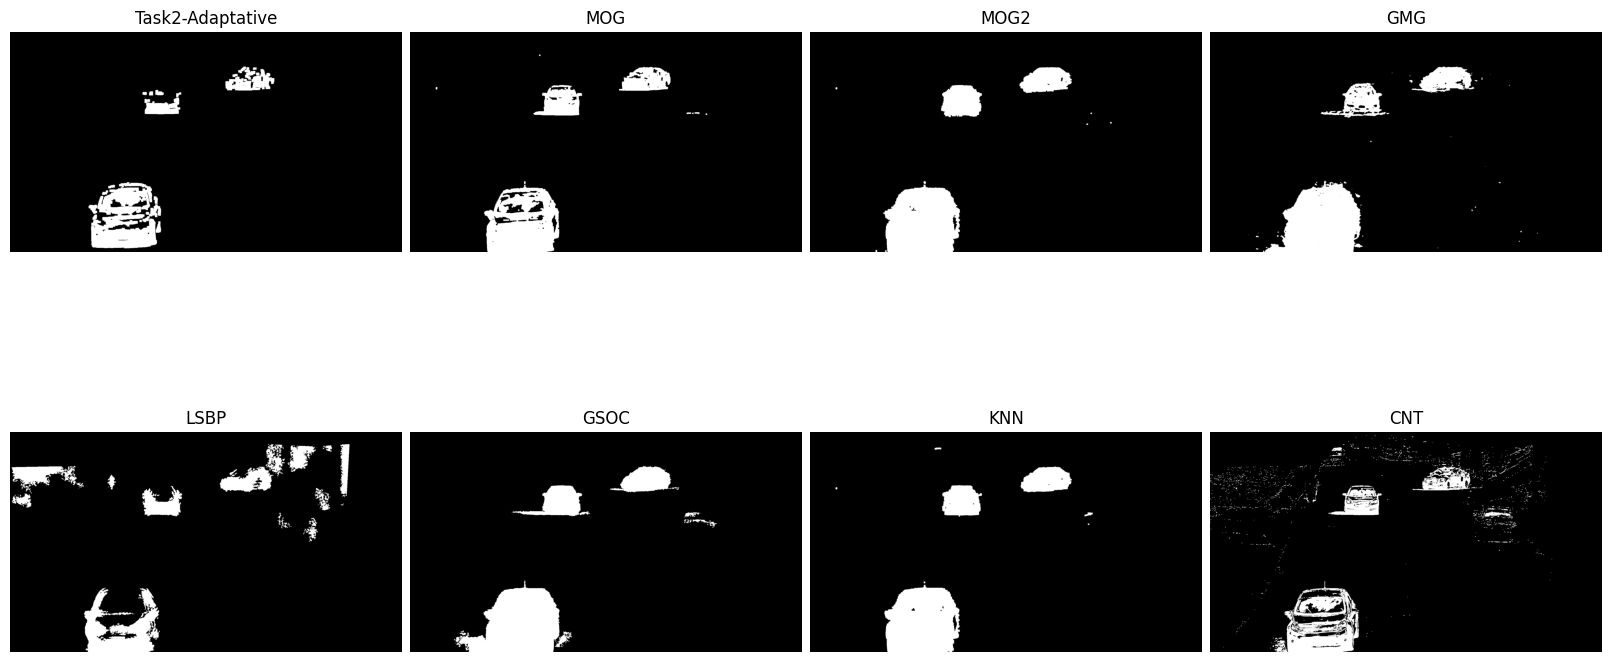

In [ ]:
fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorGMG(decisionThreshold=0.95)

models = [
    (fgbg_mog, "MOG", 1),
    (fgbg_mog2, "MOG2", 1),
    (fgbg_gmg, "GMG", 0),
    (fgbg_lsbp, "LSBP", 2),
    (fgbg_gsoc, "GSOC", 2),
    (fgbg_knn, "KNN", 1),
    (fgbg_cnt, "CNT", 2),
]


fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
axes = axes.ravel()

ax = axes[0]
ax.imshow(foreground_masks_wo_shadows[20], cmap="gray")
ax.set_title(f"Task2-Adaptative")
ax.axis("off")

for i, (fgbg, model_name, post_process) in enumerate(models, start=1):
    # warm-up / fit on training frames
    for frame in raw_frames[: train_end + 21]:
        _ = fgbg.apply(frame)

    fgmask = fgbg.apply(raw_frames[train_end + 21])  # one representative frame
    fgmask = fgmask * roi

    # keep only 255 (remove shadows=126 etc.)
    fgmask = (fgmask == 255).astype(np.uint8) * 255

    # config 1
    if post_process == 1:
        kernel = np.ones((5, 5), np.uint8)
        kernel_open = np.ones((3, 3), np.uint8)
        kernel_close = np.ones((7, 7), np.uint8)

        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel_open)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel_close)
        fgmask = cv2.dilate(fgmask, kernel, iterations=1)

    # config 2
    elif post_process == 2:
        kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel2)

    ax = axes[i]
    ax.imshow(fgmask, cmap="gray")
    ax.set_title(f"{model_name}")
    ax.axis("off")

# Hide the unused 8th slot (since you have 7 models)
for j in range(len(models), len(axes)):
    axes[j].axis("off")

plt.show()

In [ ]:
video_path = "/ghome/group02/Marina/mcv-c6-2026-team2/Week1/Data/AICity_data/train/S03/c010/vdo.avi"

frames, raw_frames = load_video_frames(video_path)

In [ ]:
frames_zbs, raw_frames_zbs = load_video_frames("/ghome/group02/Marina/mcv-c6-2026-team2/Week1/task3/results/ZBS/vdo.mp4")

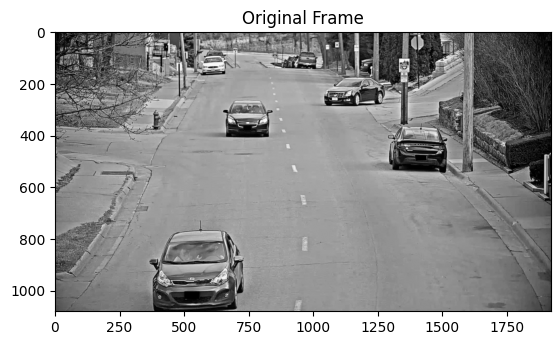

In [ ]:
plt.imshow(frames[train_end+21], cmap="gray")
plt.title("Original Frame")
plt.show()

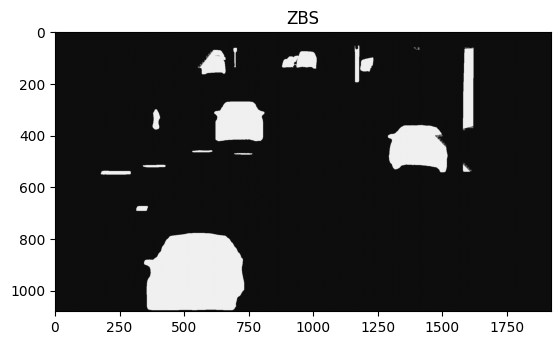

In [ ]:
plt.imshow(frames_zbs[359+21], cmap="gray")
plt.title("ZBS")
plt.show()